In [1]:
import os
import sys
import numpy as np
import scipy as sp
from scipy import optimize
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import mdtraj as md

In [2]:
pdb='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/PaaA2.pdb'
trajectory='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/PaaA2-a99SBdisp-Traj.dcd'
dihedraldir='/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/dihedrals/'
if not os.path.exists(dihedraldir):
    os.makedirs(dihedraldir)
print("pdb:", pdb)
print("dihedraldir:", dihedraldir)
print("trajectory:", trajectory)

pdb: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/PaaA2.pdb
dihedraldir: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/dihedrals/
trajectory: /Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/PaaA2-a99SBdisp-Traj.dcd


In [3]:
stride_sel=1
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [4]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])




print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 1165

Number of residues: 71

Number of frames: 29977

Starting frame: 0

Last frame: 29977

sequence:  [MET1, ASP2, TYR3, LYS4, ASP5, ASP6, ASP7, ASP8, LYS9, ASN10, ARG11, ALA12, LEU13, SER14, PRO15, MET16, VAL17, SER18, GLU19, PHE20, GLU21, THR22, ILE23, GLU24, GLN25, GLU26, ASN27, SER28, TYR29, ASN30, GLU31, TRP32, LEU33, ARG34, ALA35, LYS36, VAL37, ALA38, THR39, SER40, LEU41, ALA42, ASP43, PRO44, ARG45, PRO46, ALA47, ILE48, PRO49, HIS50, ASP51, GLU52, VAL53, GLU54, ARG55, ARG56, MET57, ALA58, GLU59, ARG60, PHE61, ALA62, LYS63, MET64, ARG65, LYS66, GLU67, ARG68, SER69, LYS70, GLN71]

residue names:  ['MET', 'ASP', 'TYR', 'LYS', 'ASP', 'ASP', 'ASP', 'ASP', 'LYS', 'ASN', 'ARG', 'ALA', 'LEU', 'SER', 'PRO', 'MET', 'VAL', 'SER', 'GLU', 'PHE', 'GLU', 'THR', 'ILE', 'GLU', 'GLN', 'GLU', 'ASN', 'SER', 'TYR', 'ASN', 'GLU', 'TRP', 'LEU', 'ARG', 'ALA', 'LYS', 'VAL', 'ALA', 'THR', 'SER', 'LEU', 'ALA', 'ASP', 'PRO', 'ARG', 'PRO', 'ALA', 'ILE', 'PRO', 'HIS', 'AS

In [5]:
combined_weights = np.loadtxt('/Users/kaushikborthakur1211/Desktop/Paper_Scripts/PaaA2/a99SBdisp/Jan_2023_leave_one_out/CA-CB-HA-H-N-C-RDC-SAXS/weights_final.dat')

In [6]:
phipsi = np.stack([md.compute_phi(trj)[-1][1:],md.compute_psi(trj)[-1][1:]])

In [7]:
resnames = np.array([residue.name for residue in trj.topology.residues])

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

In [9]:
data = phipsi

In [30]:
def plot_dihedral(data:"np.array with dimensions: (phi,psi),(N_frames),(N_residues-1)",
                  resnames:"3 letter strings of sequence", weights:"reweight data", 
                  residue:"residue type to plot", stride=1):
    
    ###
    dic = {residue:{}}
    arr_i = []
    arr_r = []
    idx_= np.where(resnames[1:-1]==residue)[0]
    ###
    
    for idx in idx_:
        fig, ax = plt.subplots(2, 2, figsize=((8,8)), sharex = True, sharey = True)
        hist_i=ax[0,0].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(), bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_r=ax[0,1].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(),weights=weights, bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_init=hist_i[0]/np.sum(hist_i[0])
        hist_re=hist_r[0]/np.sum(hist_r[0])
        xedges=hist_i[1]
        yedges=hist_i[2]

        hist_diff=hist_init - hist_re
        ax[1,0].pcolorfast(xedges, yedges, hist_diff.T,cmap='seismic')
        ax[1,1].pcolorfast(xedges, yedges, -hist_diff.T,norm=colors.LogNorm(),cmap='jet')
        
    
        ###
        dic[residue][f"{idx+2}"] = {"initial":hist_i[0], "final":hist_r[1]}
        arr_i.append(hist_i[0])
        arr_r.append(hist_r[0])
        ###
        
        for axes in ax.flat:
            axes.set_xlabel(r"$\phi$", size = 20)
            axes.set_ylabel(r"$\psi$",size = 20)
        fig.suptitle(f"{residue}:{idx+2}", fontsize=20)
   
    #####
    plt.figure()
    arr_r = np.stack(arr_r).mean(0)
    arr_i = np.stack(arr_i).mean(0)
    plt.imshow( arr_r, norm=colors.LogNorm())
    #plt.imshow( arr_r, norm=colors.LogNorm())
    plt.figure()
    plt.imshow( arr_i,norm=colors.LogNorm())
    #plt.imshow( arr_i, norm=colors.LogNorm())
    dic[residue]["average"] = dict(zip("initial,final".split(","), [arr_r,arr_i]))
    ###
    
    return dic


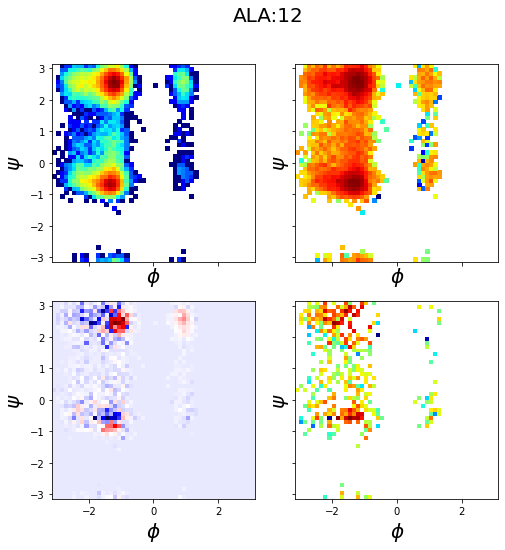

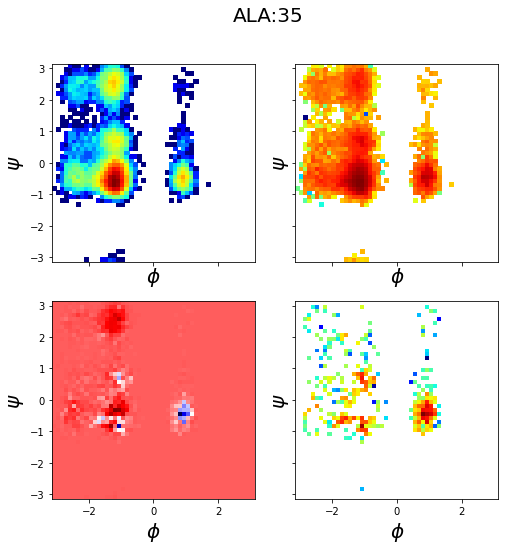

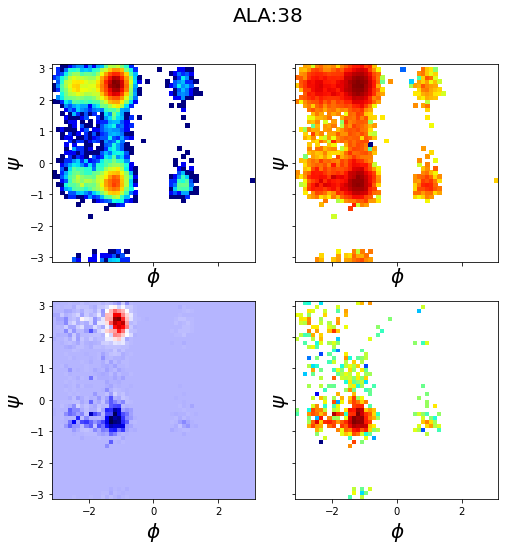

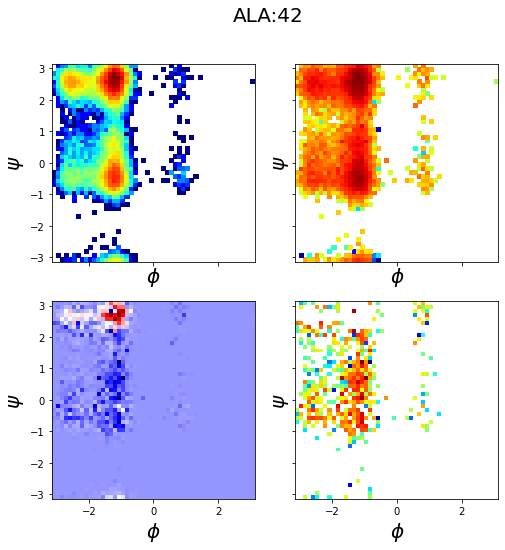

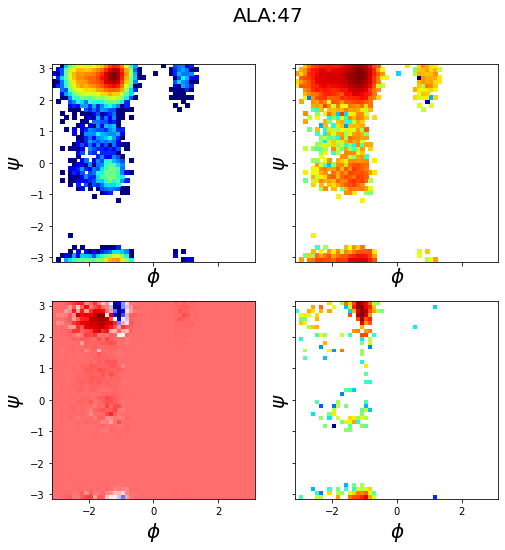

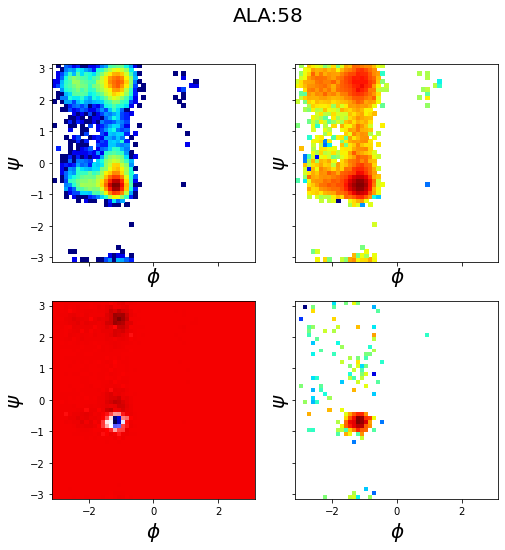

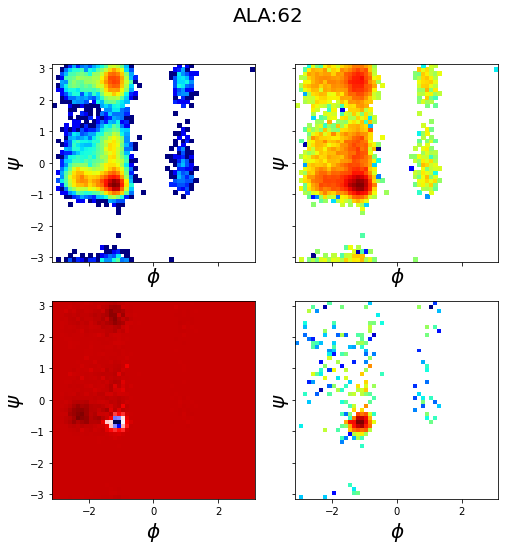

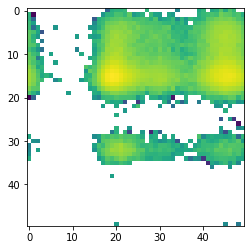

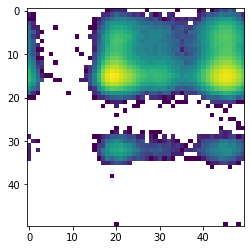

In [31]:
test=plot_dihedral(data,resnames, combined_weights, 'ALA')

In [21]:
print(test)

{'ALA': {'12': {'initial': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 6., 4., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'final': array([-3.1400000e+00, -3.0144000e+00, -2.8888000e+00, -2.7632000e+00,
       -2.6376000e+00, -2.5120000e+00, -2.3864000e+00, -2.2608000e+00,
       -2.1352000e+00, -2.0096000e+00, -1.8840000e+00, -1.7584000e+00,
       -1.6328000e+00, -1.5072000e+00, -1.3816000e+00, -1.2560000e+00,
       -1.1304000e+00, -1.0048000e+00, -8.7920000e-01, -7.5360000e-01,
       -6.2800000e-01, -5.0240000e-01, -3.7680000e-01, -2.5120000e-01,
       -1.2560000e-01,  4.4408921e-16,  1.2560000e-01,  2.5120000e-01,
        3.7680000e-01,  5.0240000e-01,  6.2800000e-01,  7.5360000e-01,
        8.7920000e-01,  1.0048000e+00,  1.1304000e+00,  1.2560000e+00,
        1.3816000e+00,  1.5072000e+00,  1.6328000e+00,  1.7584000e+00,
        1.88

In [22]:
def save_dihedral(data:"np.array with dimensions: (phi,psi),(N_frames),(N_residues-1)",
                  resnames:"3 letter strings of sequence", weights:"reweight data", 
                  residue:"residue type to plot", stride=1):
    
    ###
    dic = {residue:{}}
    arr_i = []
    arr_r = []
    idx_= np.where(resnames[1:-1]==residue)[0]
    ###
    
    for idx in idx_:
        #fig, ax = plt.subplots(2, 2, figsize=((8,8)), sharex = True, sharey = True)
        hist_i=np.histogram2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(), bins=50,range=[[-3.14,3.14],[-3.14,3.14]])
        hist_r=np.histogram2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(),weights=weights, bins=50,range=[[-3.14,3.14],[-3.14,3.14]])
        hist_init=hist_i[0]/np.sum(hist_i[0])
        hist_re=hist_r[0]/np.sum(hist_r[0])
        xedges=hist_i[1]
        yedges=hist_i[2]

        hist_diff=hist_init - hist_re
#         ax[1,0].pcolorfast(xedges, yedges, hist_diff.T,cmap='seismic')
#         ax[1,1].pcolorfast(xedges, yedges, -hist_diff.T,norm=colors.LogNorm(),cmap='jet')
        
    
        ###
        dic[residue][f"{idx+2}"] = {"initial":hist_i[0], "final":hist_r[1]}
        arr_i.append(hist_i[0])
        arr_r.append(hist_r[0])
        ###
        
#         for axes in ax.flat:
#             axes.set_xlabel(r"$\phi$", size = 20)
#             axes.set_ylabel(r"$\psi$",size = 20)
#         fig.suptitle(f"{residue}:{idx+2}", fontsize=20)
   
    #####
#     plt.figure()
    arr_r = np.stack(arr_r).mean(0)
    arr_i = np.stack(arr_i).mean(0)
    #plt.imshow( arr_r, norm=colors.LogNorm(), interpolation = "bessel")
#     plt.imshow( arr_r, norm=colors.LogNorm())
#     plt.figure()
    #plt.imshow( arr_i, norm=colors.LogNorm(), interpolation = "bessel")
#     plt.imshow( arr_i, norm=colors.LogNorm())
    dic[residue]["average"] = dict(zip("initial,final".split(","), [arr_r,arr_i]))
    ###
    
    return dic


In [23]:
save_dihedral(data,resnames, combined_weights, 'ALA')

{'ALA': {'12': {'initial': array([[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 6., 4., 1.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]),
   'final': array([-3.1400000e+00, -3.0144000e+00, -2.8888000e+00, -2.7632000e+00,
          -2.6376000e+00, -2.5120000e+00, -2.3864000e+00, -2.2608000e+00,
          -2.1352000e+00, -2.0096000e+00, -1.8840000e+00, -1.7584000e+00,
          -1.6328000e+00, -1.5072000e+00, -1.3816000e+00, -1.2560000e+00,
          -1.1304000e+00, -1.0048000e+00, -8.7920000e-01, -7.5360000e-01,
          -6.2800000e-01, -5.0240000e-01, -3.7680000e-01, -2.5120000e-01,
          -1.2560000e-01,  4.4408921e-16,  1.2560000e-01,  2.5120000e-01,
           3.7680000e-01,  5.0240000e-01,  6.2800000e-01,  7.5360000e-01,
           8.7920000e-01,  1.0048000e+00,  1.1304000e+00,  1.2560000e+00,
           1.3816000e+00,  1.5072000e+

In [36]:
def plot_dihedral(data:"np.array with dimensions: (phi,psi),(N_frames),(N_residues-1)",
                  resnames:"3 letter strings of sequence", weights:"reweight data", 
                  residue:"residue type to plot", stride=1):
    
    ###
    dic = {residue:{}}
    arr_i = []
    arr_r = []
    idx_= np.where(resnames[1:-1]==residue)[0]
    ###
    
    for idx in idx_:
        fig, ax = plt.subplots(2, 2, figsize=((8,8)), sharex = True, sharey = True)
        hist_i=ax[0,0].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(), bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_r=ax[0,1].hist2d(data[0,::stride,idx+1].flatten(), data[-1,::stride,idx].flatten(),weights=weights, bins=50,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
        hist_init=hist_i[0]/np.sum(hist_i[0])
        hist_re=hist_r[0]/np.sum(hist_r[0])
        xedges=hist_i[1]
        yedges=hist_i[2]

        hist_diff=hist_init - hist_re
        ax[1,0].pcolorfast(xedges, yedges, hist_diff.T,cmap='seismic')
        ax[1,1].pcolorfast(xedges, yedges, -hist_diff.T,norm=colors.LogNorm(),cmap='jet')
        
    
        ###
        dic[residue][f"{idx+2}"] = {"initial":hist_i[0], "final":hist_r[1]}
        arr_i.append(hist_i[0])
        arr_r.append(hist_r[0])
        ###
        
        for axes in ax.flat:
            axes.set_xlabel(r"$\phi$", size = 20)
            axes.set_ylabel(r"$\psi$",size = 20)
        fig.suptitle(f"{residue}:{idx+2}", fontsize=20)
   
    #####
    #plt.figure()
    arr_r = np.stack(arr_r).mean(0)
    arr_i = np.stack(arr_i).mean(0)
    plt.hist( arr_r, norm=colors.LogNorm(), range=[[-3.14,3.14],[-3.14,3.14]])
    #plt.imshow( arr_r, norm=colors.LogNorm())
    plt.figure()
    plt.hist( arr_i,norm=colors.LogNorm(), range=[[-3.14,3.14],[-3.14,3.14]])
    #plt.imshow( arr_i, norm=colors.LogNorm())
    dic[residue]["average"] = dict(zip("initial,final".split(","), [arr_r,arr_i]))
    ###
    
    return dic


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

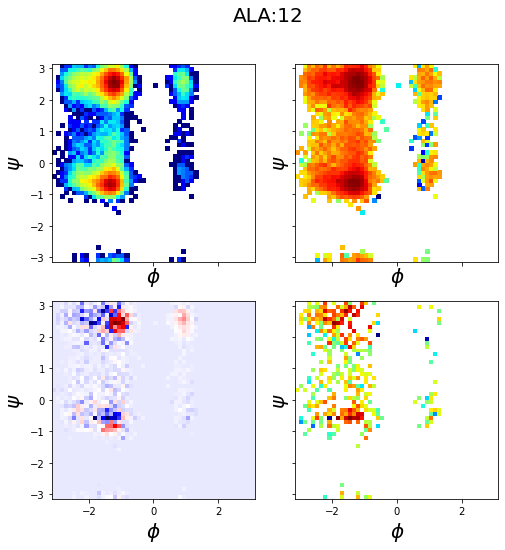

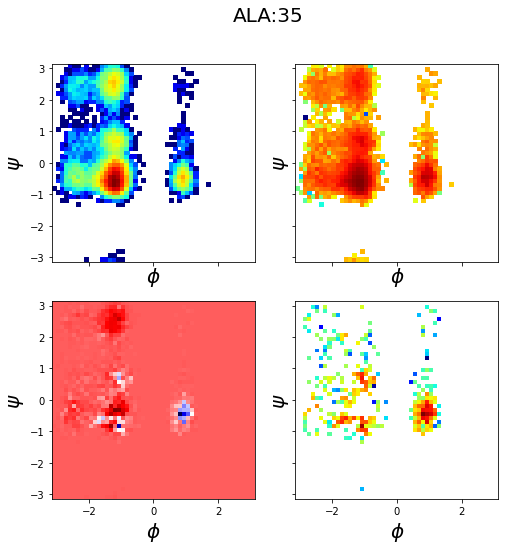

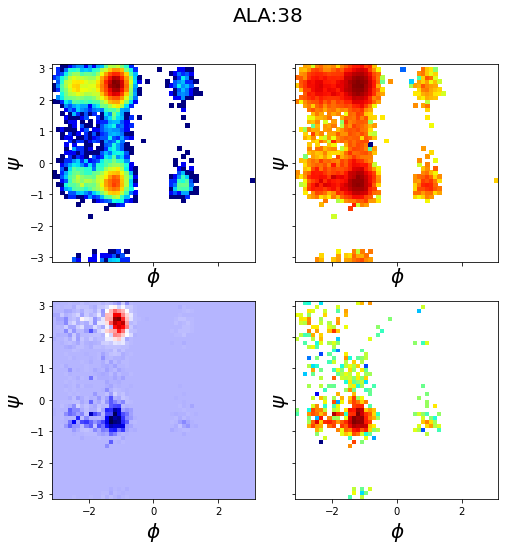

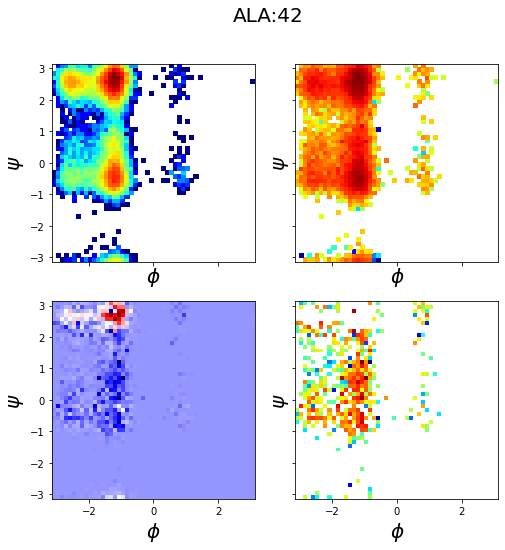

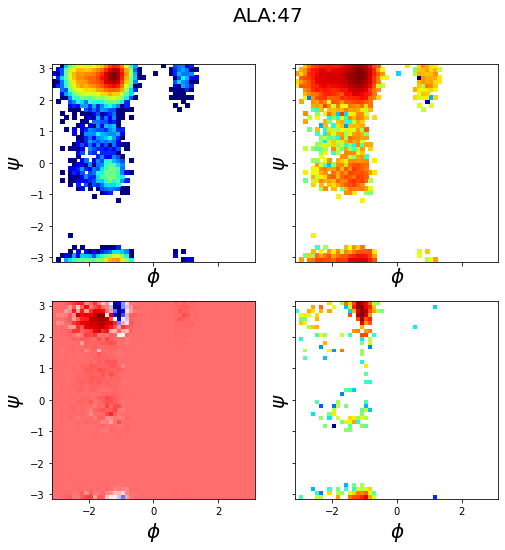

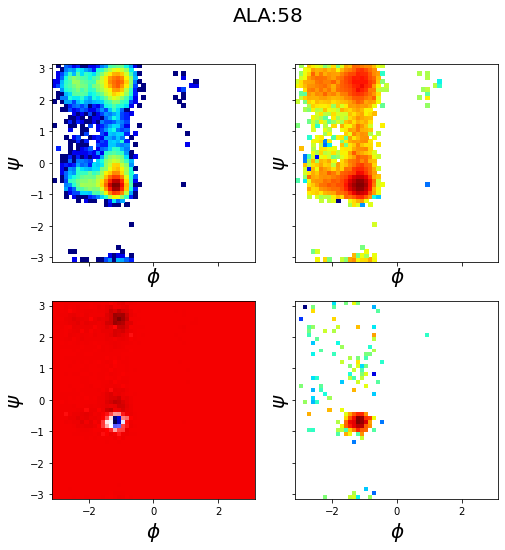

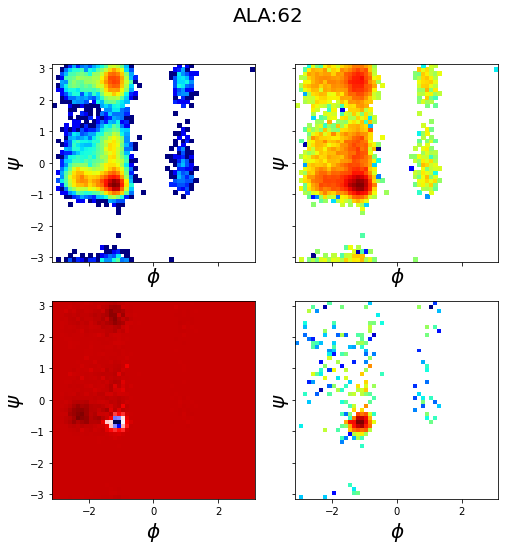

In [38]:
test=plot_dihedral(data,resnames, combined_weights, 'ALA')

/Users/kaushikborthakur1211/opt/anaconda3/envs/New_env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


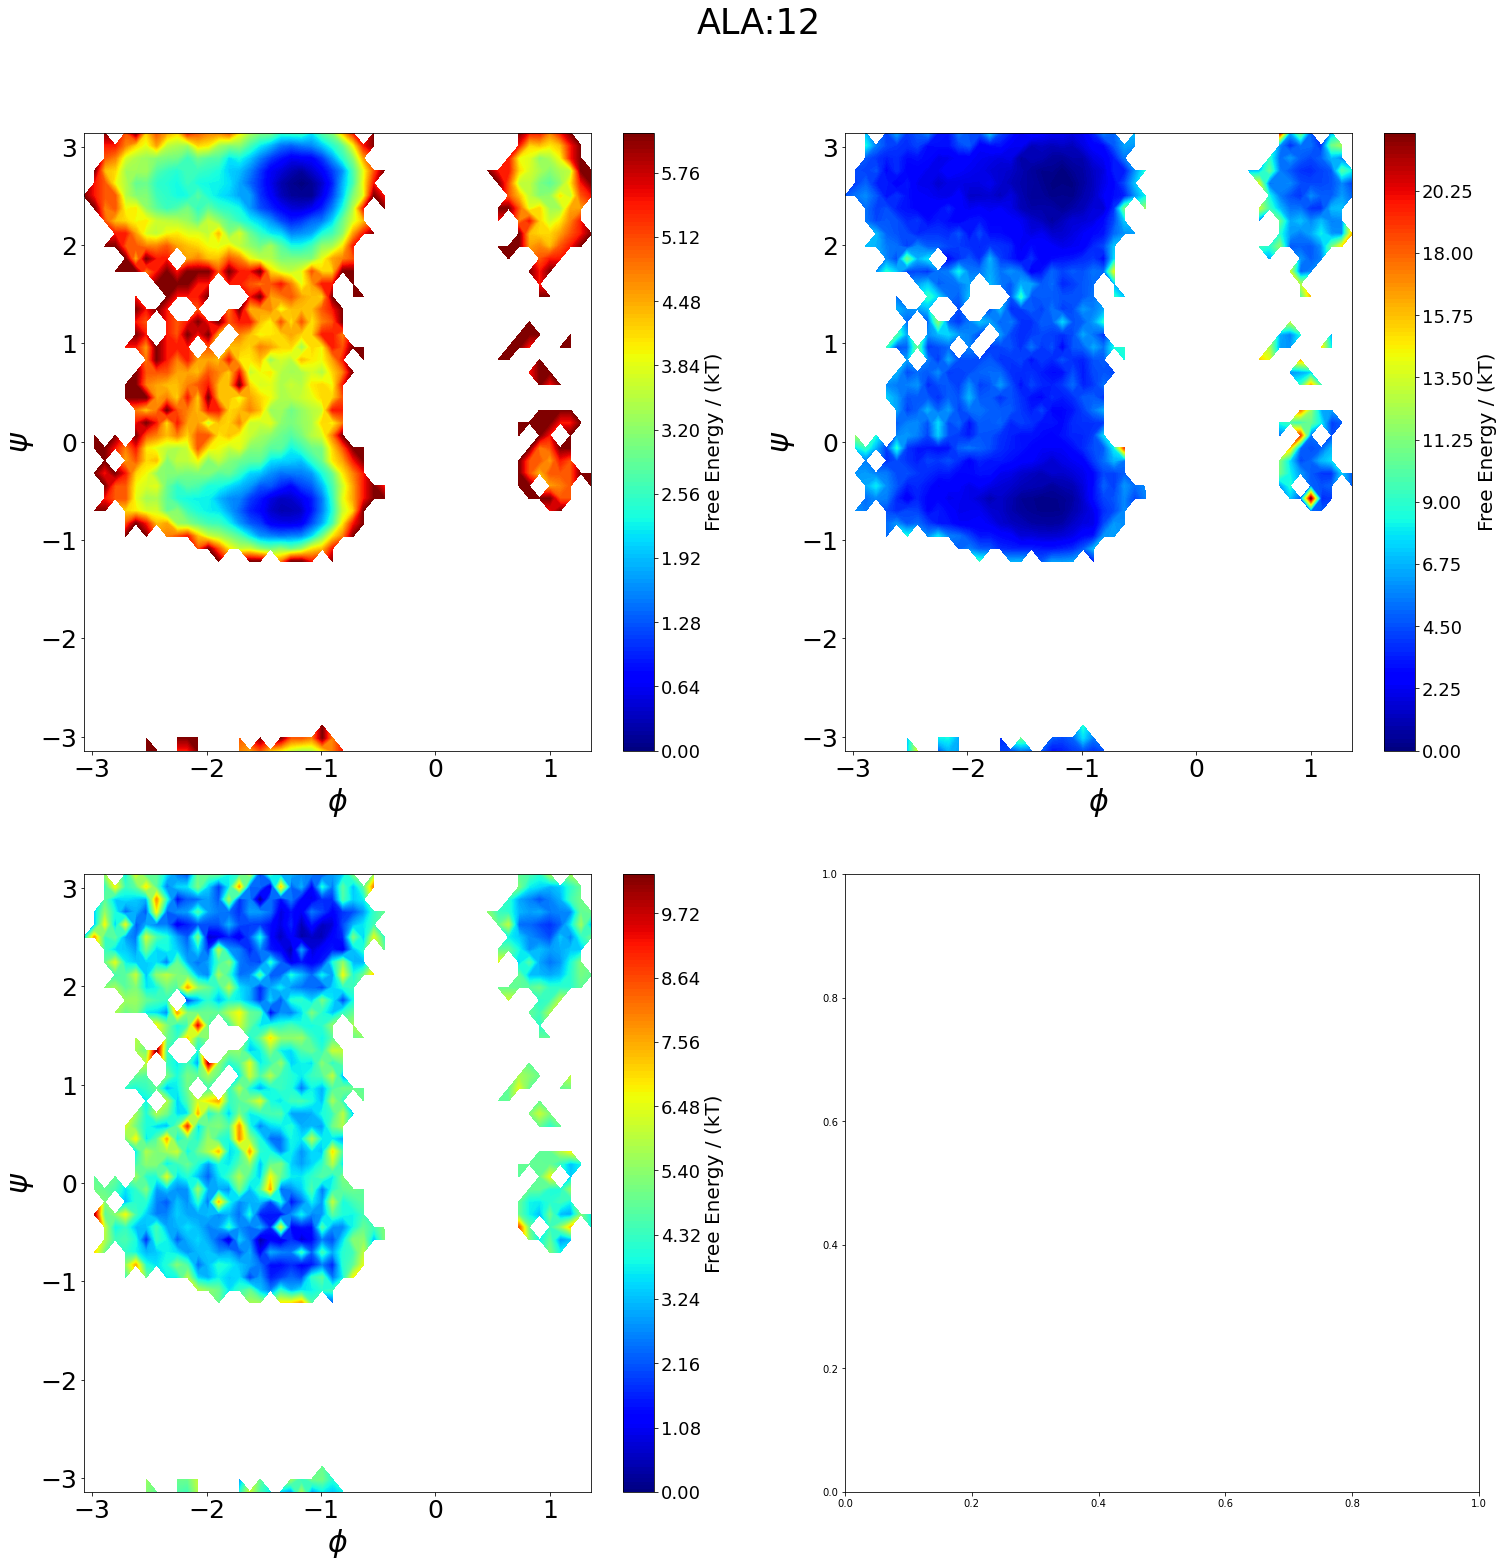

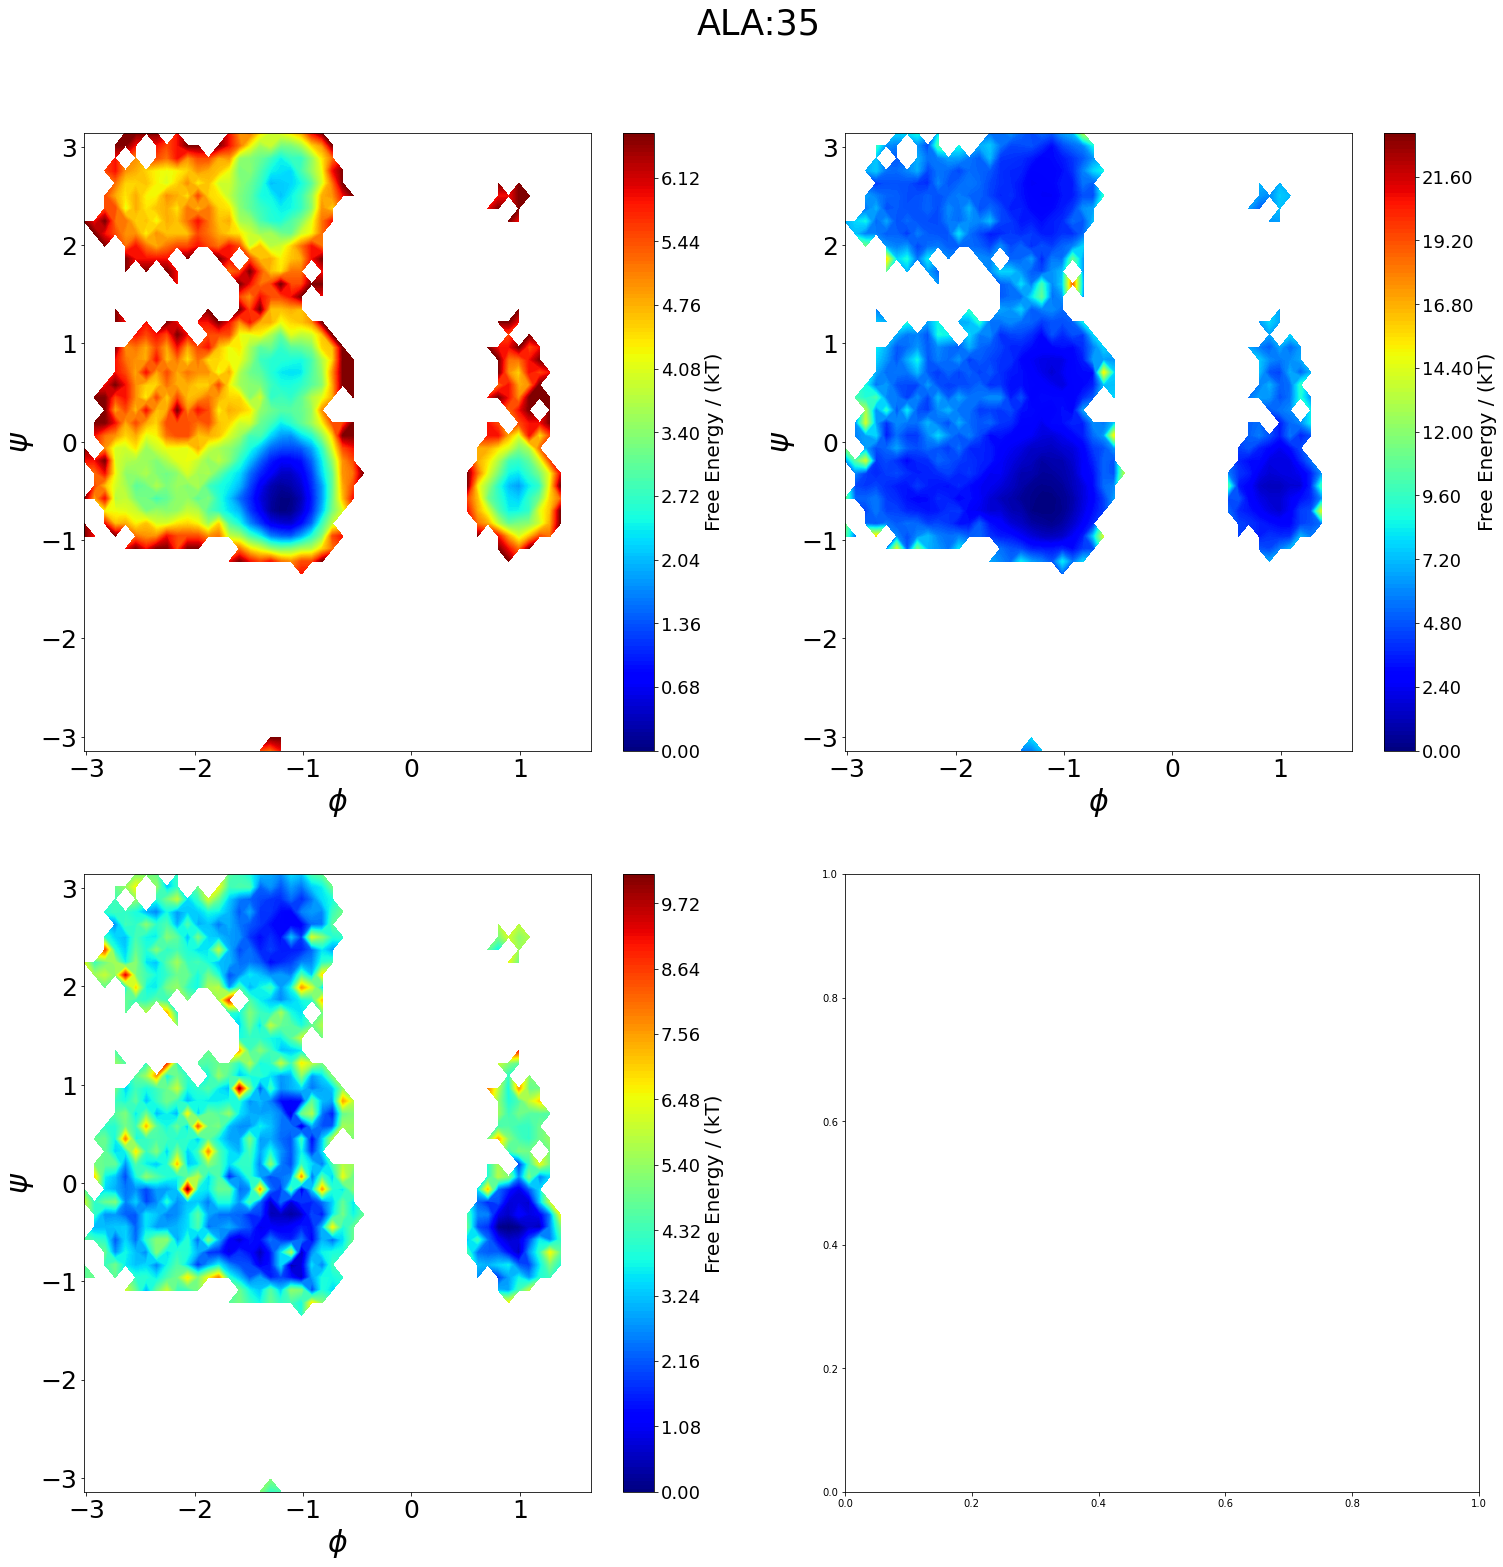

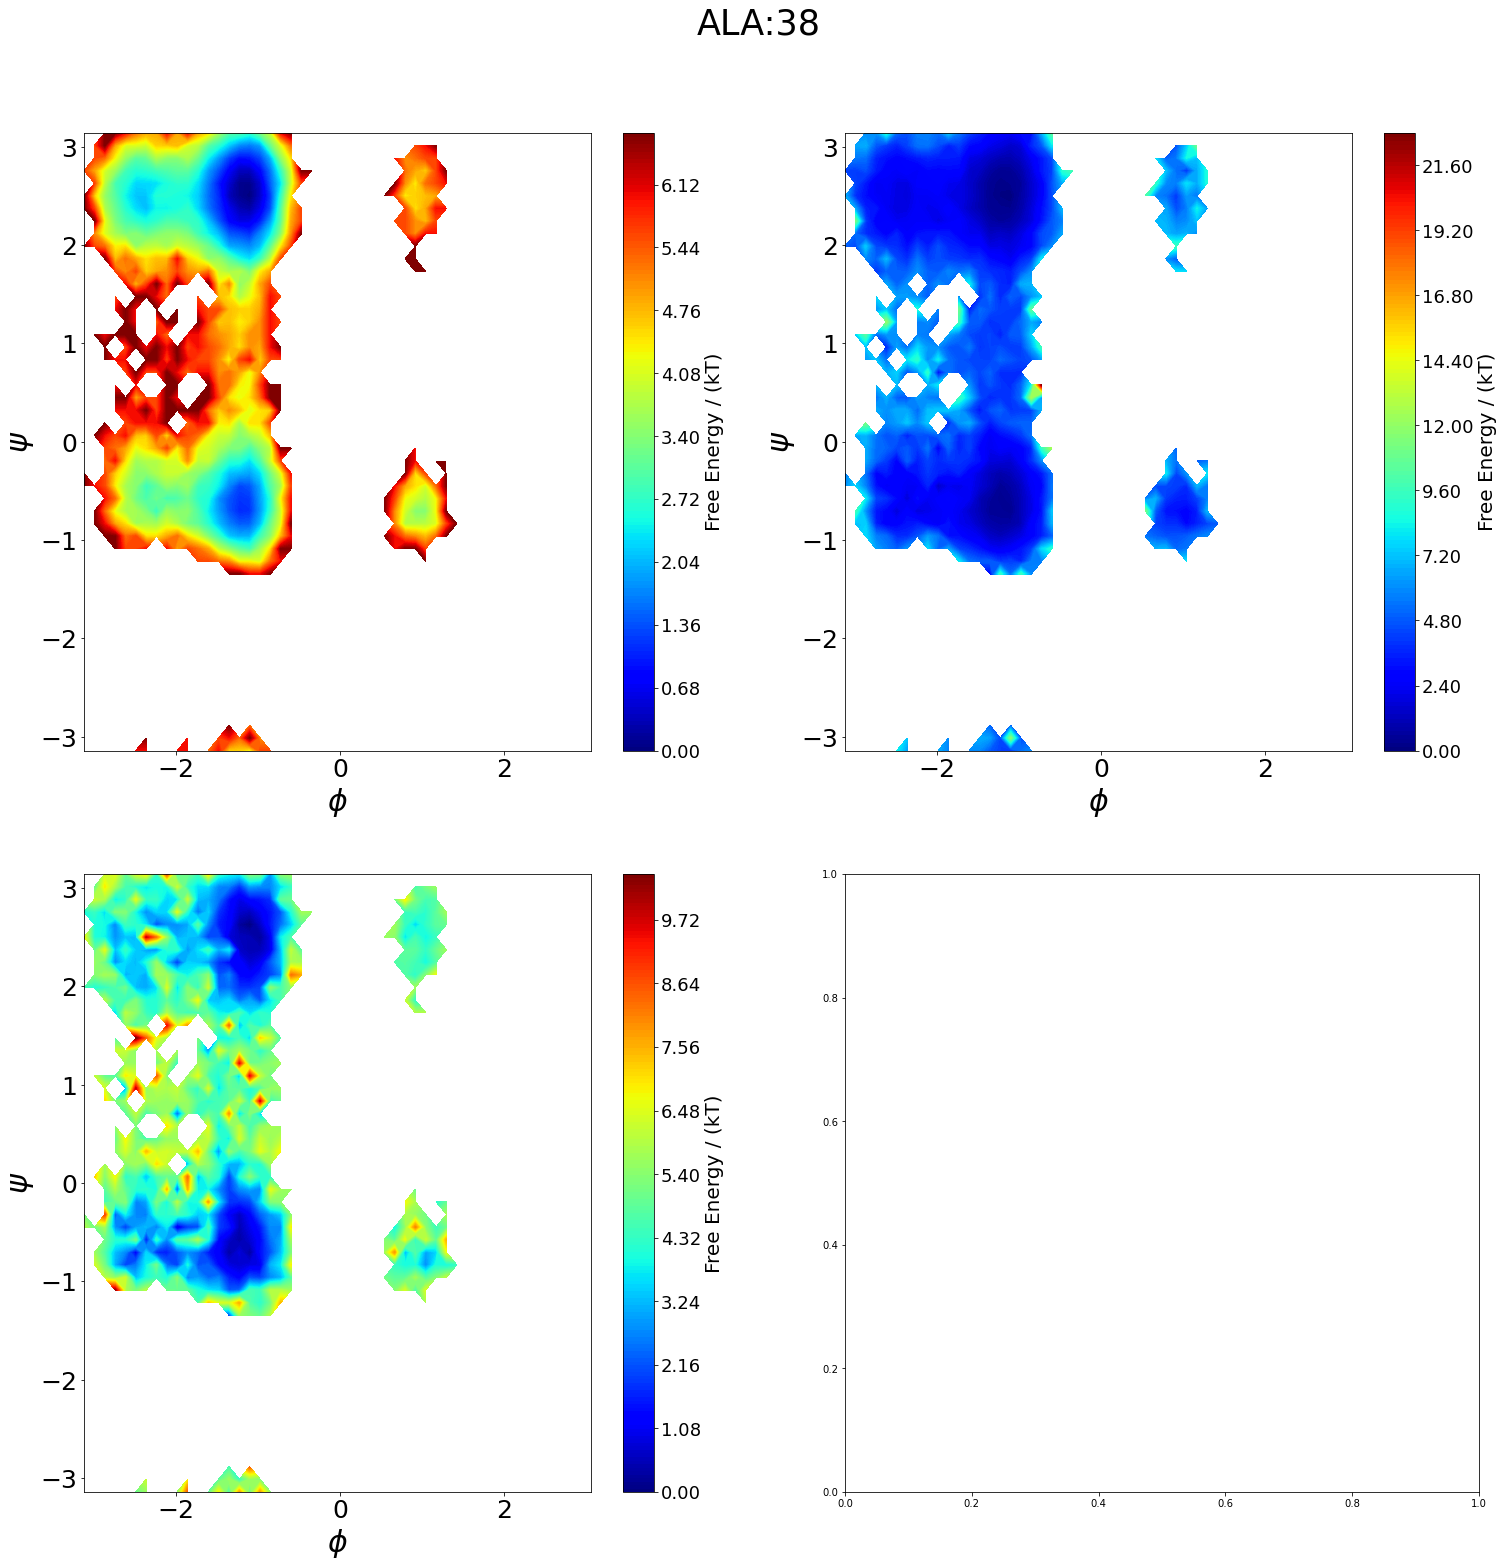

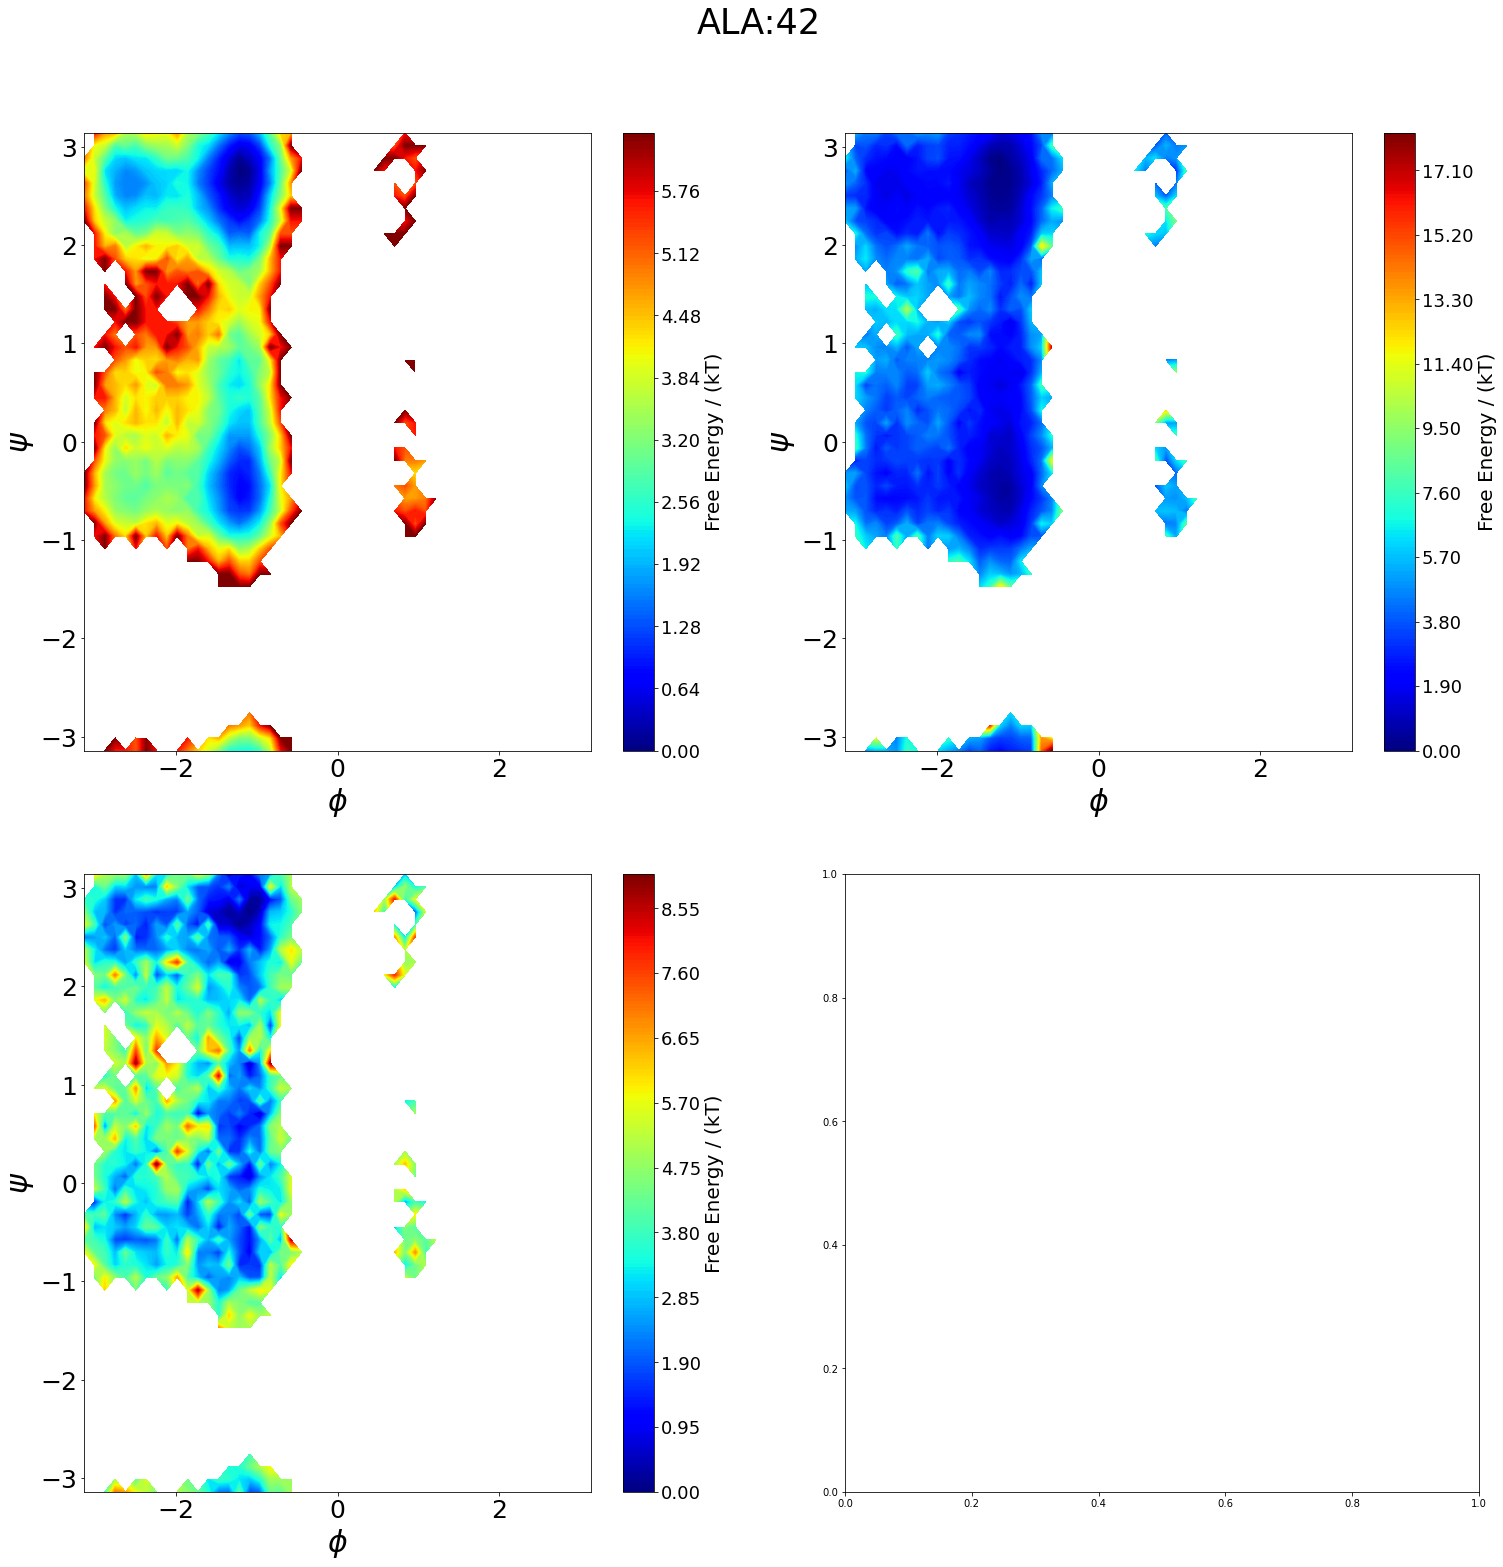

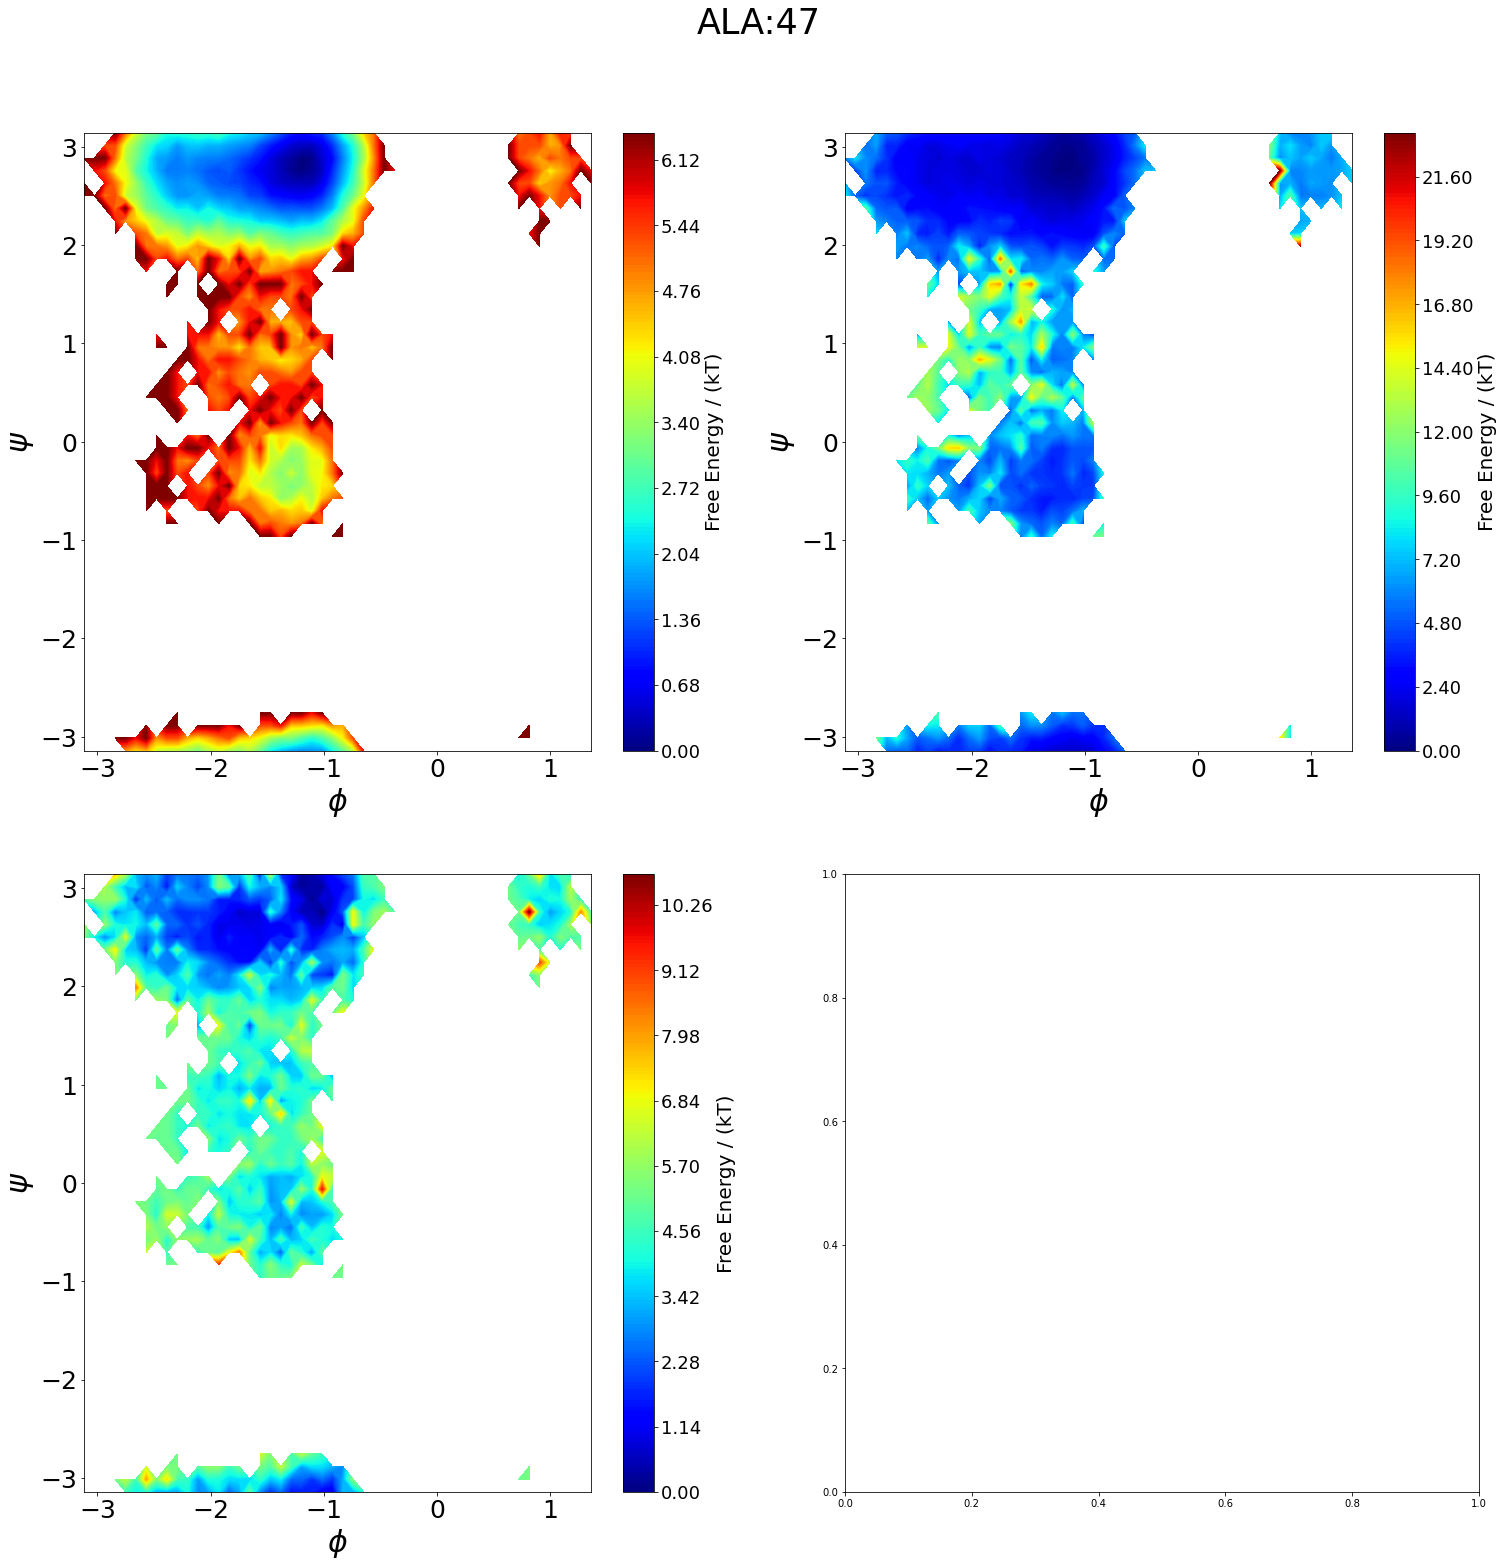

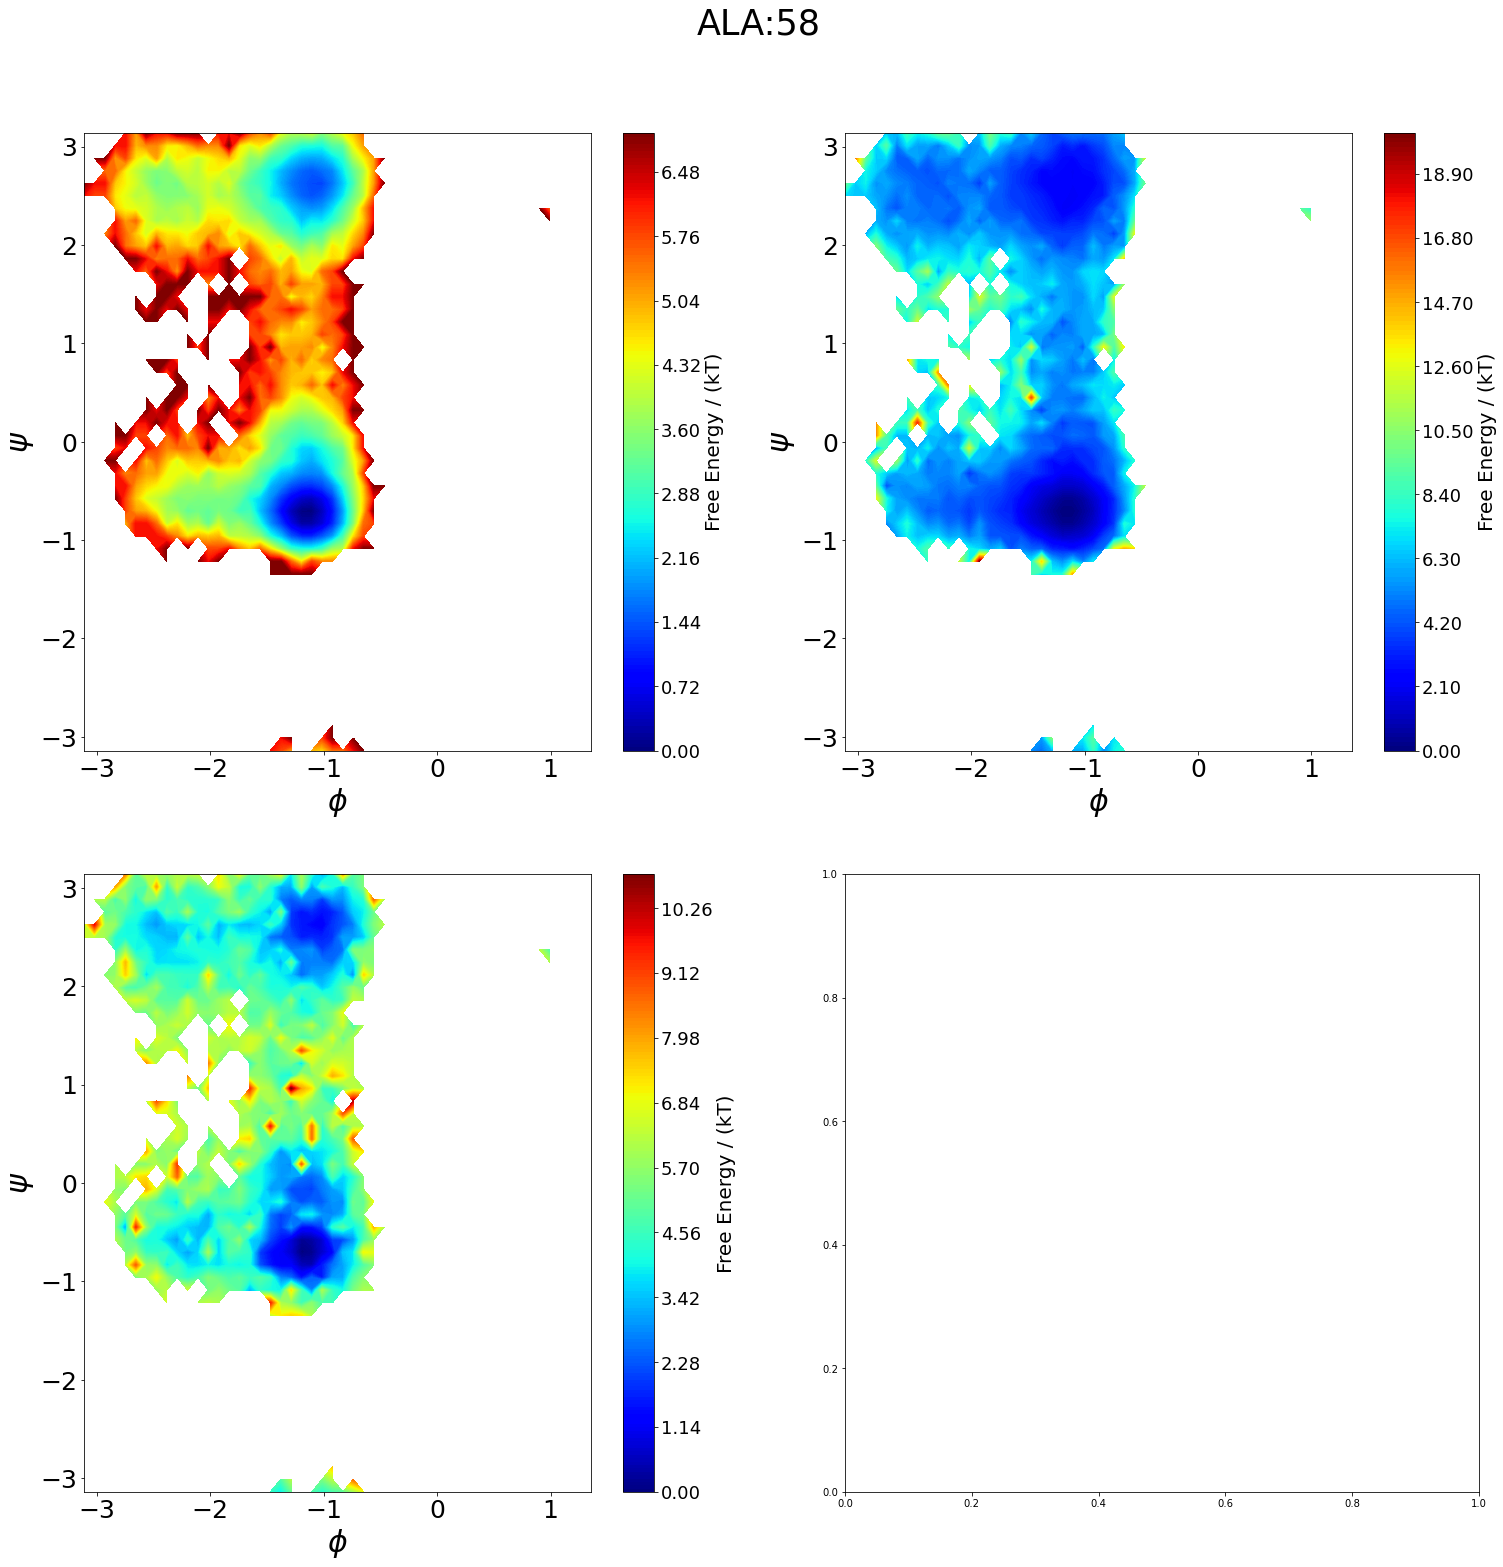

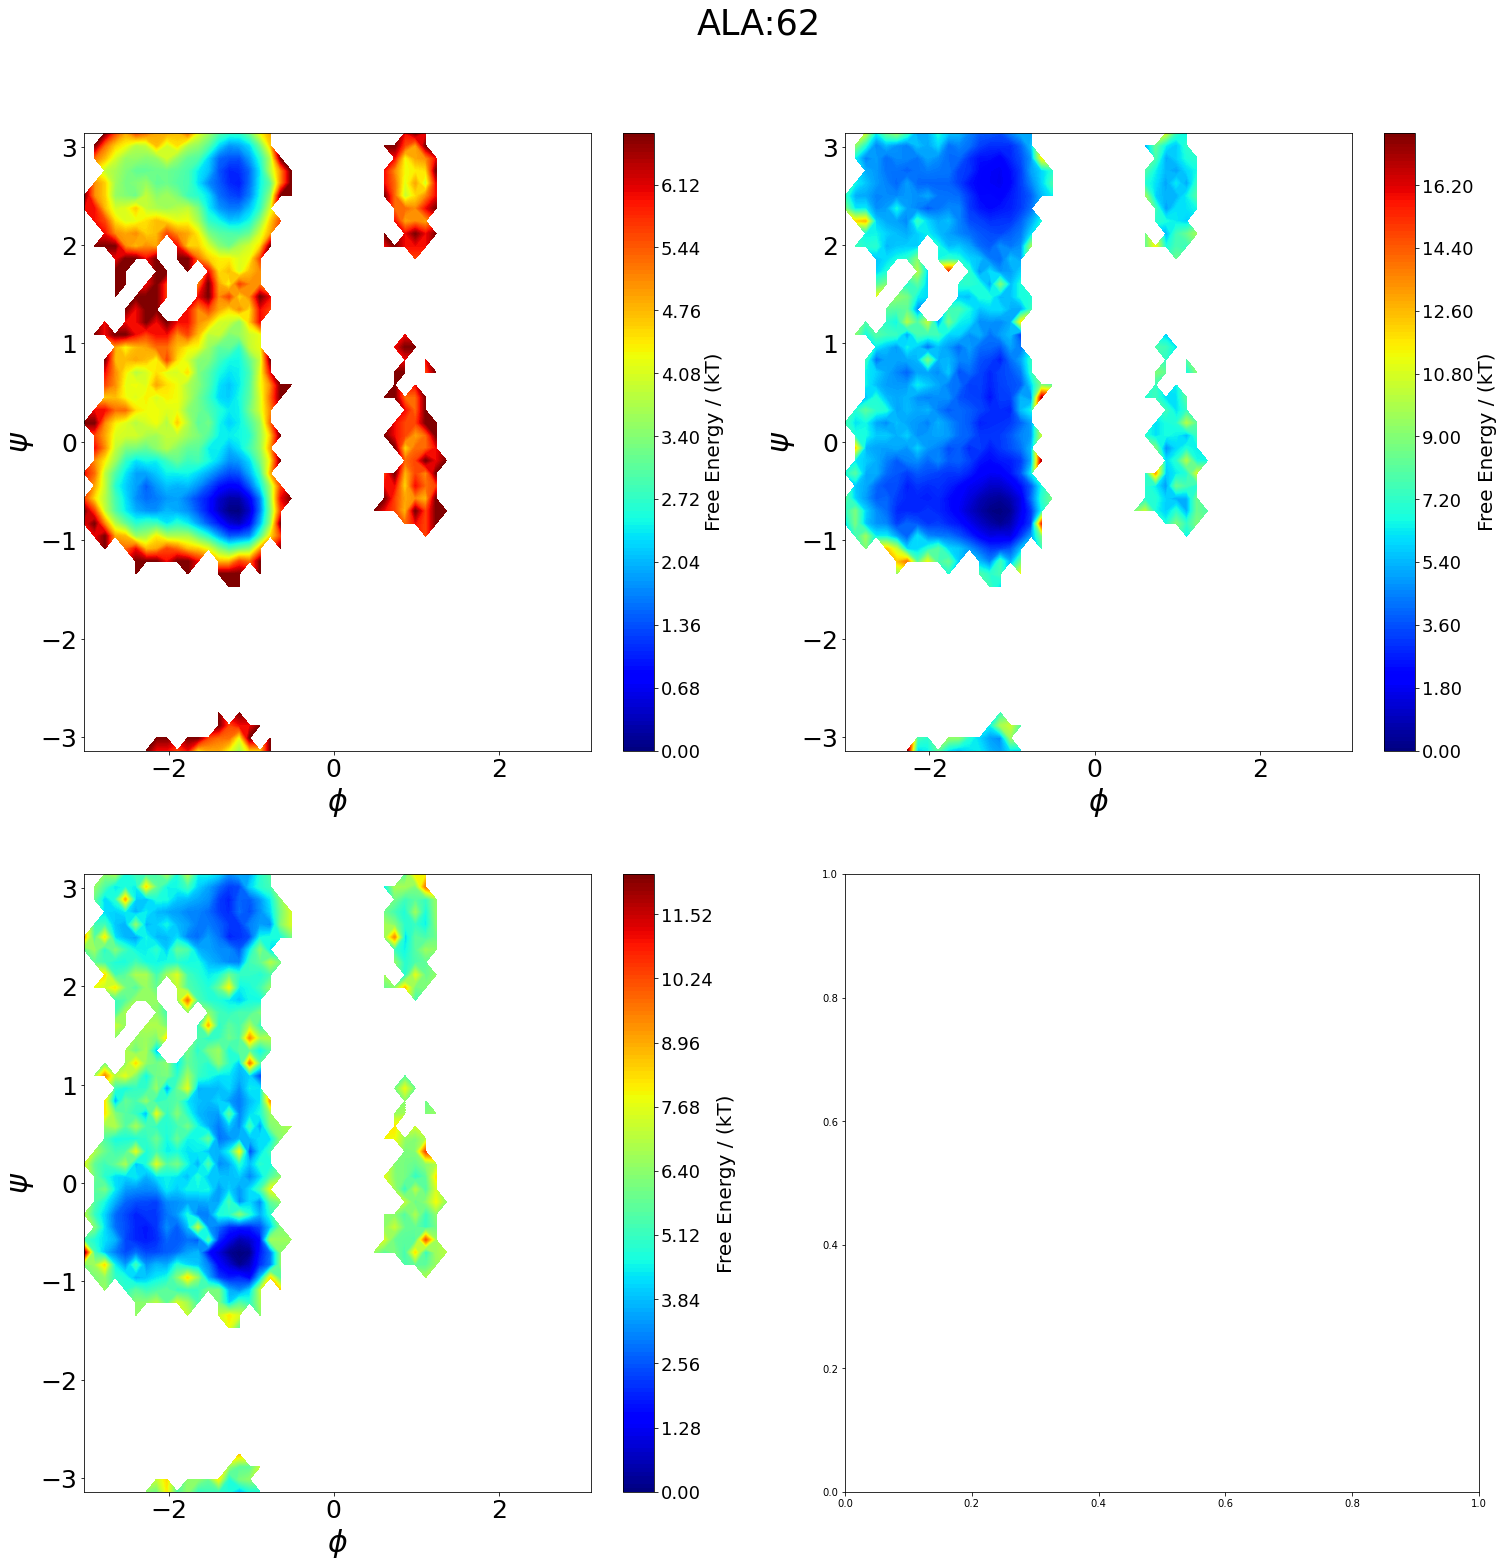

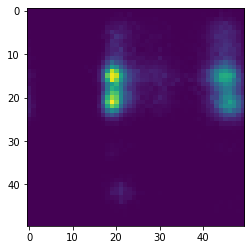

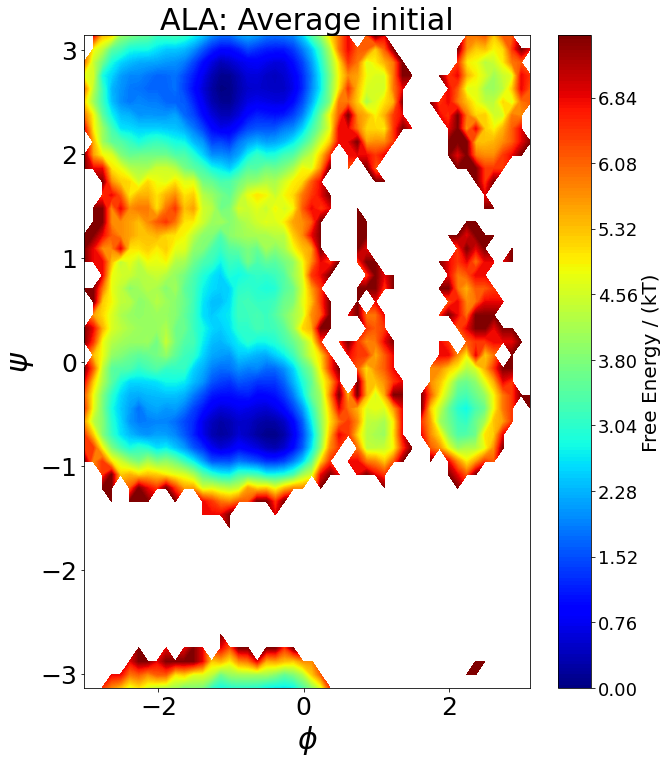

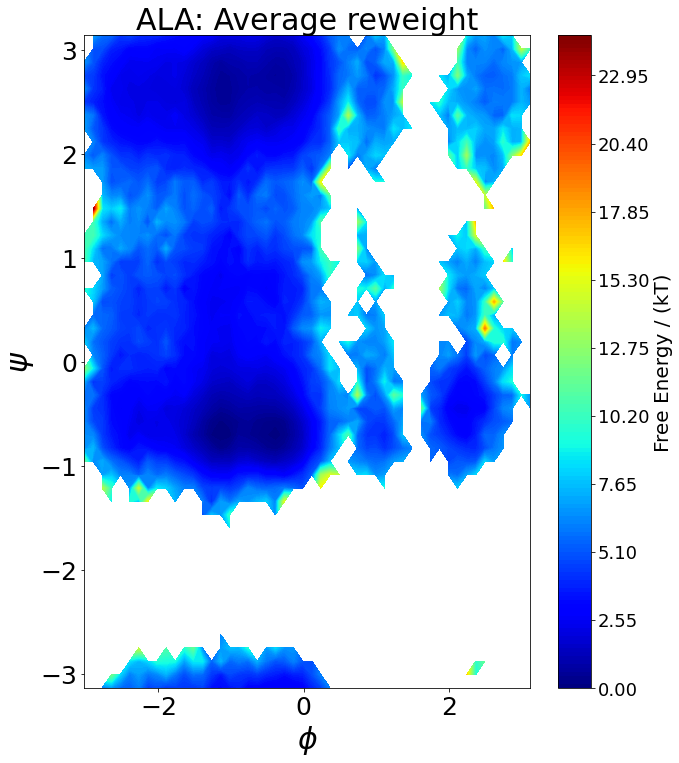

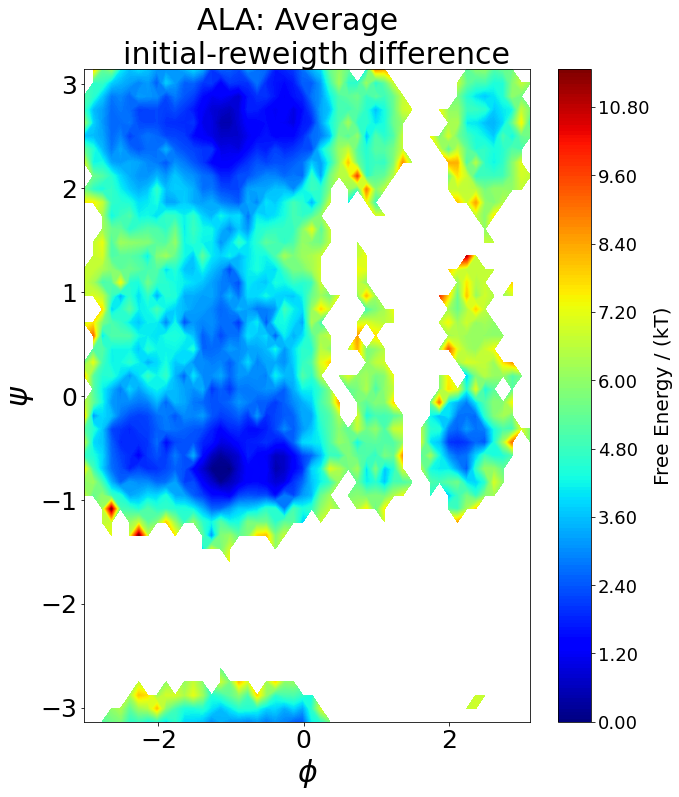

In [41]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

def fes2d(x,y,labels:"list[xlabel,ylabel,title]", weights=None, ax=None, bins=50, arr = False, title=None):
    if not isinstance(arr, np.ndarray):
        z,x,y = np.histogram2d(x,y,bins=bins, weights=weights)
        arr = np.ma.masked_array(z,z==0)
    extent = (x.min(), x.max(), y.min(), y.max())
    F=-np.log(arr)
    F+=-F.min()
    F = F
    if ax == None:fig,ax=plt.subplots(1,1,figsize=(10,12),sharex=True,sharey=True)
    a=ax.contourf(F.T,200,cmap="jet",extent=extent,zorder=-1)
    ax.set_xlabel(labels[0],fontsize=30)
    ax.set_ylabel(labels[-1],fontsize=30)
    ax.tick_params(axis="both",labelsize=25)
    cb = plt.colorbar(a,ax=ax, format = "%.2f")
    cb.set_label("Free Energy / (kT)",size=20)
    cb.ax.tick_params(labelsize = 18)
    if isinstance(title, str):ax.set_title(title, size=30)
    return arr,x,y

data = phipsi
names = np.ones(20).astype(str); names[[3,5,2,0]] ="ALA"
#import matplotlib.pyplot.colors as colors
def plot_dihedral(data:"np.array with dimensions: (phi,psi),(N_frames),(N_residues-1)",
                  resnames:"3 letter strings of sequence", weights:"reweight data", 
                  residue:"residue type to plot", stride=1,
                 labels=["$\phi$","$\psi$"]):
    
    ###
    dic = {residue:{}}
    arr_i = []
    arr_r = []
    arr_d = []
    idx_= np.where(resnames[1:-1]==residue)[0]
    ###
    
    for idx in idx_:
        fig, ax = plt.subplots(2, 2, figsize=((25,25)))
        hist_i= fes2d(x=data[0,::stride,idx+1].flatten(), y=data[-1,::stride,idx].flatten(),ax=ax[0,0],
                     labels=labels)
        hist_r= fes2d(x=data[0,::stride,idx+1].flatten(), y=data[-1,::stride,idx].flatten(),ax=ax[0,1],
                      weights= weights, labels=labels)
        xedges=hist_i[1]
        yedges=hist_i[2]
        
        hist_init=hist_i[0]/np.sum(hist_i[0])
        hist_re=hist_r[0]/np.sum(hist_r[0])
        hist_diff= abs(hist_init-hist_re)
        fes2d(x=xedges,y=yedges,arr=hist_diff, labels=labels, ax=ax[1,0])
        ###
        dic[residue][f"{idx+2}"] = {"initial":hist_i[0], "reweight":hist_r[0]}
        dic[residue][f"{idx+2}"] = {"difference":hist_diff}
        arr_i.append(hist_i[0])
        arr_r.append(hist_r[0])
        arr_d.append(hist_diff)
        ###
        
        fig.suptitle(f"{residue}:{idx+2}", fontsize=35, y=.95)
        plt.tight_layout
    
    #####
    plt.figure()
    arr_r,arr_i,arr_d = [np.stack(i).mean(0) for i in [arr_r,arr_i,arr_d]]
    plt.imshow(arr_r)
    fes2d(x=xedges,y=yedges,arr=arr_i, labels=labels, title=f"{residue}: Average initial")
    fes2d(x=xedges,y=yedges,arr=arr_r, labels=labels, title=f"{residue}: Average reweight")
    fes2d(x=xedges,y=yedges,arr=arr_d, labels=labels, title=f"{residue}: Average  \n  initial-reweigth difference")
    dic[residue]["average"] = dict(zip("initial,reweight,difference".split(","), [arr_i,arr_r,arr_d]))
    ###
    
    return dic, arr_r
dic, arr = plot_dihedral(data, resnames,  combined_weights,"ALA")

In [42]:
dic

{'ALA': {'12': {'difference': masked_array(
     data=[[--, --, --, ..., --, --, --],
           [--, --, --, ..., --, --, --],
           [--, --, --, ..., 3.667511095368223e-05, 6.309014570069665e-05,
            1.818108434986722e-05],
           ...,
           [--, --, --, ..., 5.0577871700246206e-05, 6.641005970081617e-05,
            1.4989928349752339e-05],
           [--, --, --, ..., 2.71330866517641e-05, 3.3289979350411144e-05,
            --],
           [--, --, --, ..., --, --, --]],
     mask=[[ True,  True,  True, ...,  True,  True,  True],
           [ True,  True,  True, ...,  True,  True,  True],
           [ True,  True,  True, ..., False, False, False],
           ...,
           [ True,  True,  True, ..., False, False, False],
           [ True,  True,  True, ..., False, False,  True],
           [ True,  True,  True, ...,  True,  True,  True]],
     fill_value=1e+20)},
  '35': {'difference': masked_array(
     data=[[--, --, --, ..., --, --, --],
           [--, 